# Project 8

## CONTENTS<a class="anchor" id="sommaire"></a>
### 1 - [Setting Environment and Importing Libraries](#1)<a class="anchor" id="sommaire"></a>
### 2 - [Spark Session](#2)<a class="anchor" id="sommaire"></a>
### 3 - [Connecting to S3 and Importing Images](#3)<a class="anchor" id="sommaire"></a>
### 4 - [ResNet 50 Model](#4)<a class="anchor" id="sommaire"></a>
### 5 - [Dimensionality reduction](#5)<a class="anchor" id="5"></a>

### 1 - [Setting Environment and Importing Libraries](#1)<a class="anchor" id="1"></a>

In [1]:
import os

# setting the environment variables SPARK_HOME and PYSPARK_SUBMIT_ARGS :
os.environ['SPARK_HOME'] = '/home/ubuntu/spark-3.1.2-bin-hadoop2.7/'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.2 pyspark-shell'

In [2]:
import findspark
findspark.init()

In [3]:
import io
from io import StringIO

import sys
import time
import urllib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image, ImageOps

from pyspark import SparkContext, SparkConf
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler, StringIndexer
from pyspark.ml.linalg import Vectors, VectorUDT

from pyspark.sql import Window
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, IntegerType, FloatType, StringType
from pyspark.sql.functions import split, col, udf
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.functions import monotonically_increasing_id, row_number

# boto3 to connect to S3
import boto3

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing import image

Using TensorFlow backend.


### 2 - [Spark Session](#2)<a class="anchor" id="2"></a>

In [4]:
# Create Session
spark = (SparkSession
             .builder.master('local[*]')
             .appName('p8') 
             .config('spark.hadoop.fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem') 
             .getOrCreate()
            )

:: loading settings :: url = jar:file:/home/ubuntu/spark-3.1.2-bin-hadoop2.7/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
com.amazonaws#aws-java-sdk-pom added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-b67156ad-5287-4eee-9803-586389c416dc;1.0
	confs: [default]
	found com.amazonaws#aws-java-sdk-pom;1.10.34 in central
	found org.apache.hadoop#hadoop-aws;2.7.2 in central
	found org.apache.hadoop#hadoop-common;2.7.2 in central
	found org.apache.hadoop#hadoop-annotations;2.7.2 in central
	found com.google.guava#guava;11.0.2 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found commons-cli#commons-cli;1.2 in central
	found org.apache.commons#commons-math3;3.1.1 in central
	found xmlenc#xmlenc;0.52 in central
	found commons-httpclient#commons-httpclient;3.1 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.4 in central
	found commons-io#comm

In [5]:
spark

In [6]:
# set system properties
sc = SparkContext.getOrCreate()
sc.setSystemProperty('com.amazonaws.services.s3.enableV4', 'true')
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3.us-east-1.amazonaws.com")
sc.setLogLevel('WARN')
sc

<SparkContext master=local[*] appName=p8>

### 3 - [Connecting to S3 and Importing Images](#3)<a class="anchor" id="3"></a>

In [7]:
connexion = boto3.client('s3')
connexion

In [8]:
# use connexion.list_objects to return objects in our desired  bucket
contents = connexion.list_objects(Bucket='fruit-folders-bucket')['Contents']
contents[0]

{'Key': 'my_folder_fruits/Apple Braeburn/109_100.jpg',
 'LastModified': datetime.datetime(2021, 10, 31, 12, 11, 11, tzinfo=tzlocal()),
 'ETag': '"562fb71e112bec530ac9d6b9b2b4393d"',
 'Size': 4750,
 'StorageClass': 'STANDARD',
 'Owner': {'DisplayName': 'lauraamydaines+aws',
  'ID': 'f33c3d09fb3f11b7378e2e5fb876ee2573413479ccf00132c0dd0510993389ea'}}

In [9]:
# check number of contents in bucket
len(contents)

776

In [10]:
# path_fruits will contain the path for each file in our dataset
path_fruits = []

for photo in contents:
    file = photo['Key']
    path_fruits.append(file)

file

'my_folder_fruits/Watermelon/r_255_100.jpg'

In [11]:
# how many paths in path_fruits
len(path_fruits)

776

In [12]:

zipped = zip(path_fruits)

cols = ['image_path']

# df_fruits is a spark dataframe made from lst_fruit, therefore df_fruits contains the path for each file in our dataset
# and has only the one column, named "image_path"
df_fruits = spark.createDataFrame(zipped, cols)
df_fruits

DataFrame[image_path: string]

In [13]:
# check size of created spark dataframe
df_fruits.count(), len(df_fruits.columns)

(776, 1)

In [14]:
def get_folder_name(path):
    """
    function that returns folder name when given the path to an image
    """
    ls_path = path.split('/')
    # returns fruit folder name
    fruit_folder = ls_path[-2] 
    return fruit_folder

# use udf to create a user defined function (UDF), in this case, it a returns fruit folder name
udf_getfolder = udf(get_folder_name, StringType())
udf_getfolder

<function __main__.get_folder_name(path)>

In [15]:
# use pyspark.sql.DataFrame.withColumn to return a new DataFrame by adding a column or replacing the existing column 
# that has the same name.  
# so we create a new column in the df_fruits dataframe, with the folder name / label of the fruit
df_fruits = df_fruits.withColumn('label', udf_getfolder('image_path'))

# check size of spark dataframe with added column
df_fruits.count(), len(df_fruits.columns)

(776, 2)

In [16]:
df_fruits.show(5)

+--------------------+--------------+
|          image_path|         label|
+--------------------+--------------+
|my_folder_fruits/...|Apple Braeburn|
|my_folder_fruits/...|Apple Braeburn|
|my_folder_fruits/...|Apple Braeburn|
|my_folder_fruits/...|Apple Braeburn|
|my_folder_fruits/...|Apple Braeburn|
+--------------------+--------------+
only showing top 5 rows



### 4 - [ResNet 50 Model](#4)<a class="anchor" id="4"></a>

Use ResNet 50 to extract features

In [20]:
model = ResNet50(include_top = False, weights = 'imagenet')
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [21]:
bc_model_weights = spark.sparkContext.broadcast(model.get_weights())

In [22]:
# use model removing last layer, as to get features before final prediction and use pre-trained weights on ImageNet
model = ResNet50(
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg',
    input_shape = (224, 224, 3),
)
model.summary()

model.set_weights(bc_model_weights.value)

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [25]:
resnet_fts = []

for photo in contents:
    # path is the path to the image
    path = photo['Key']
    obj = bucket.Object(path)

    # use : .get() to retrieves objects from Amazon S3 
    img_body = obj.get()['Body']
    
    # resize image
    img = Image.open(img_body).resize((224, 224))

    # use expand_dims to expand the shape of array.
    img_arr = np.expand_dims(img, axis=0)

    # from tensorflow.keras.applications.resnet50 we imported : preprocess_input
    img_pss = preprocess_input(img_arr)

    # use numpy.ravel(a, order='C') to return a contiguous flattened array of the features we got 
    # from the output of the ResNet model, for the current image. 
    resnet_ft = model.predict(img_pss).ravel().tolist()
    
    # append resnet_fts so that we have all the features for each image in one place
    resnet_fts.append(resnet_ft)

In [26]:
len(resnet_fts)

776

In [27]:
# create a dataframe with the features from ResNet, with a single column : features
sdf_resnet = spark.createDataFrame([(f,) for f in resnet_fts], ['rs50_fts'])
sdf_resnet

DataFrame[rs50_fts: array<double>]

In [28]:
sdf_resnet.count(), len(sdf_resnet.columns)

21/11/08 19:14:44 WARN TaskSetManager: Stage 5 contains a task of very large size (6993 KiB). The maximum recommended task size is 1000 KiB.


(776, 1)

In [30]:
# check number of features output from the ResNet50 model
len(sdf_resnet.collect()[1]['rs50_fts'])

21/11/08 19:15:17 WARN TaskSetManager: Stage 8 contains a task of very large size (6993 KiB). The maximum recommended task size is 1000 KiB.


2048

In [31]:
sdf_resnet.dtypes

[('rs50_fts', 'array<double>')]

Add a column indicating row numbers and join dfs

In [32]:
# create a new column within the sdf_resnet df, named row_index, to get row number
sdf_resnet= sdf_resnet.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
sdf_resnet

DataFrame[rs50_fts: array<double>, row_index: int]

In [33]:
sdf_resnet.count(), len(sdf_resnet.columns)

21/11/08 19:16:06 WARN TaskSetManager: Stage 9 contains a task of very large size (6993 KiB). The maximum recommended task size is 1000 KiB.


(776, 2)

In [34]:
sdf_resnet.dtypes

[('rs50_fts', 'array<double>'), ('row_index', 'int')]

In [35]:
# create a new column within the df_fruits df, named row_index, to get row number
df_fruits = df_fruits.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
df_fruits

DataFrame[image_path: string, label: string, row_index: int]

In [36]:
df_fruits.count(), len(df_fruits.columns)

(776, 3)

In [37]:
# merge image_sdf with temp_sdf
merged_fruit = df_fruits.join(sdf_resnet, df_fruits.row_index == sdf_resnet.row_index).drop('row_index')
merged_fruit

DataFrame[image_path: string, label: string, rs50_fts: array<double>]

In [38]:
merged_fruit.dtypes

[('image_path', 'string'), ('label', 'string'), ('rs50_fts', 'array<double>')]

In [39]:
# use .dense to create a dense vector of 64-bit floats from a Python list 
# VectorUDT() SQL user-defined type (UDT) for Vector.
to_vector = udf(lambda x: Vectors.dense(x), VectorUDT())

# choose columns we want from the df, and change the features column from list to vector
merged_fruit = merged_fruit.select('image_path', 'label', to_vector('rs50_fts').alias('fts_vec'))
merged_fruit

DataFrame[image_path: string, label: string, fts_vec: vector]

### 5 - [Dimensionality reduction](#5)<a class="anchor" id="5"></a>

In [40]:
standardizer = StandardScaler(withMean=True, withStd=True,
                              inputCol='fts_vec',
                              outputCol='scaled_fts')
standardizer

StandardScaler_c2f312e6952a

In [42]:
std = standardizer.fit(merged_fruit)
std

21/11/08 19:20:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/11/08 19:20:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/11/08 19:20:59 WARN TaskSetManager: Stage 18 contains a task of very large size (6993 KiB). The maximum recommended task size is 1000 KiB.


StandardScalerModel: uid=StandardScaler_c2f312e6952a, numFeatures=2048, withMean=true, withStd=true

In [43]:
scaled_fruit = std.transform(merged_fruit)
scaled_fruit

DataFrame[image_path: string, label: string, fts_vec: vector, scaled_fts: vector]

In [44]:
scaled_fruit.show(8)

21/11/08 19:21:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/11/08 19:21:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/11/08 19:21:45 WARN TaskSetManager: Stage 22 contains a task of very large size (6993 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------+--------------------+--------------------+
|          image_path|         label|             fts_vec|          scaled_fts|
+--------------------+--------------+--------------------+--------------------+
|my_folder_fruits/...|Apple Braeburn|[1.75877547264099...|[1.51345953050516...|
|my_folder_fruits/...|Apple Braeburn|[1.10375285148620...|[0.64160307864166...|
|my_folder_fruits/...|Apple Braeburn|[0.86600953340530...|[0.32515897570236...|
|my_folder_fruits/...|Apple Braeburn|[0.32772943377494...|[-0.3913093761006...|
|my_folder_fruits/...|Apple Braeburn|[0.18190620839595...|[-0.5854048405505...|
|my_folder_fruits/...|Apple Braeburn|[0.12685634195804...|[-0.6586780065115...|
|my_folder_fruits/...|Apple Braeburn|[0.66223341226577...|[0.05392631867138...|
|my_folder_fruits/...|Apple Braeburn|[0.77620333433151...|[0.20562399851061...|
+--------------------+--------------+--------------------+--------------------+
only showing top 8 rows



In [46]:
scaled_fruit = scaled_fruit.select('image_path', 'label', 'scaled_fts')
scaled_fruit

DataFrame[image_path: string, label: string, scaled_fts: vector]

In [47]:
dim_pca = 250
pca = PCA(k = dim_pca,
          inputCol='scaled_fts', 
          outputCol='pca_output',
         )
pca

PCA_1df20a47c907

In [48]:
pca_model = pca.fit(scaled_fruit)
pca_model

21/11/08 19:22:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/11/08 19:22:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/11/08 19:22:49 WARN TaskSetManager: Stage 25 contains a task of very large size (6993 KiB). The maximum recommended task size is 1000 KiB.
21/11/08 19:22:55 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/11/08 19:22:55 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
21/11/08 19:22:58 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
21/11/08 19:22:58 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


PCAModel: uid=PCA_1df20a47c907, k=250

In [49]:
pca_fruit = pca_model.transform(scaled_fruit)
pca_fruit

DataFrame[image_path: string, label: string, scaled_fts: vector, pca_output: vector]

In [50]:
pca_fruit = pca_fruit.select('image_path', 'label', 'pca_output')
pca_fruit

DataFrame[image_path: string, label: string, pca_output: vector]

In [51]:
pca_fruit.show(8)

21/11/08 19:24:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/11/08 19:24:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/11/08 19:24:00 WARN TaskSetManager: Stage 40 contains a task of very large size (6993 KiB). The maximum recommended task size is 1000 KiB.
21/11/08 19:24:00 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


+--------------------+--------------+--------------------+
|          image_path|         label|          pca_output|
+--------------------+--------------+--------------------+
|my_folder_fruits/...|Apple Braeburn|[9.81892420753113...|
|my_folder_fruits/...|Apple Braeburn|[9.79578602222267...|
|my_folder_fruits/...|Apple Braeburn|[9.7510622461536,...|
|my_folder_fruits/...|Apple Braeburn|[16.3130919373966...|
|my_folder_fruits/...|Apple Braeburn|[13.8083523441111...|
|my_folder_fruits/...|Apple Braeburn|[12.9501248641129...|
|my_folder_fruits/...|Apple Braeburn|[16.8753516568244...|
|my_folder_fruits/...|Apple Braeburn|[16.6183094834451...|
+--------------------+--------------+--------------------+
only showing top 8 rows



In [52]:
pca_model.explainedVariance

DenseVector([0.0701, 0.0412, 0.0381, 0.0324, 0.0296, 0.0259, 0.0236, 0.0225, 0.0183, 0.0177, 0.0168, 0.0155, 0.0146, 0.0142, 0.0136, 0.0131, 0.0121, 0.0116, 0.0109, 0.0098, 0.0094, 0.0093, 0.0092, 0.0088, 0.0083, 0.0081, 0.0078, 0.0076, 0.0075, 0.0074, 0.007, 0.0068, 0.0065, 0.006, 0.0059, 0.0058, 0.0057, 0.0056, 0.0053, 0.0052, 0.005, 0.0049, 0.0047, 0.0046, 0.0045, 0.0044, 0.0044, 0.0043, 0.0042, 0.0042, 0.0041, 0.004, 0.0039, 0.0039, 0.0038, 0.0036, 0.0036, 0.0035, 0.0035, 0.0033, 0.0033, 0.0032, 0.0032, 0.0031, 0.0031, 0.003, 0.003, 0.0029, 0.0028, 0.0028, 0.0028, 0.0027, 0.0027, 0.0026, 0.0026, 0.0025, 0.0025, 0.0025, 0.0025, 0.0024, 0.0024, 0.0023, 0.0023, 0.0023, 0.0022, 0.0022, 0.0022, 0.0022, 0.0021, 0.0021, 0.0021, 0.0021, 0.002, 0.002, 0.002, 0.0019, 0.0019, 0.0019, 0.0019, 0.0018, 0.0018, 0.0018, 0.0018, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0014, 0.0014, 0.0014, 0.0014, 0.00

In [54]:
# use numpy.cumsum to get the cumulative sum of the elements along a given axis
var_cumul = pca_model.explainedVariance.cumsum()
len(var_cumul)

250

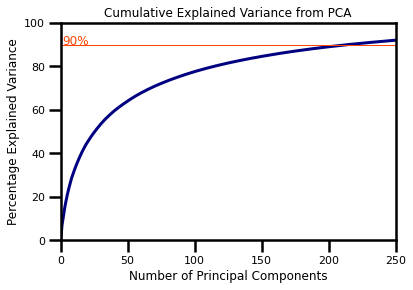

In [57]:
sns.set_context(context='poster', font_scale = 0.5)

sns.lineplot(x = [i for i in range(dim_pca + 1)], 
             y = np.insert(var_cumul, 0, 0) * 100, color = 'navy')

plt.title('Cumulative Explained Variance from PCA')
plt.xlabel('Number of Principal Components')
plt.ylabel('Percentage Explained Variance')
plt.ylim(0, 100)
plt.xlim(left = 0, right = 250)
plt.axhline(90, lw = 1, c = 'orangered')
plt.text(1, 90, '90%', c = 'orangered')
plt.show()


In [58]:
# we chose to keep 200 components

dim_pca = 200
pca = PCA(k = dim_pca,
          inputCol='scaled_fts', 
          outputCol='pca_output'
          )
pca_model = pca.fit(scaled_fruit)
pca_fruit = pca_model.transform(scaled_fruit)
pca_fruit = pca_fruit.select('image_path', 'label', 'pca_output')
pca_fruit

21/11/08 19:28:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/11/08 19:28:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/11/08 19:28:13 WARN TaskSetManager: Stage 42 contains a task of very large size (6993 KiB). The maximum recommended task size is 1000 KiB.


DataFrame[image_path: string, label: string, pca_output: vector]

In [59]:
# use numpy.cumsum to get the cumulative sum of the elements along a given axis
var_cumul = pca_model.explainedVariance.cumsum()
var_cumul

array([0.07008849, 0.11127964, 0.1493657 , 0.18174749, 0.21137923,
       0.23726973, 0.26088909, 0.28337675, 0.3016983 , 0.31938442,
       0.33616844, 0.35167444, 0.36632218, 0.38056156, 0.39421139,
       0.40728286, 0.41934858, 0.43097275, 0.44186603, 0.45166445,
       0.46107895, 0.4703748 , 0.47961206, 0.4884362 , 0.49673573,
       0.50487063, 0.51269882, 0.52031869, 0.52783615, 0.53521543,
       0.54220072, 0.54904343, 0.55557903, 0.56162863, 0.56757476,
       0.57340559, 0.57914692, 0.58472631, 0.59004987, 0.59526482,
       0.60028124, 0.60515666, 0.60987512, 0.61450325, 0.61902358,
       0.62342684, 0.62778682, 0.6320529 , 0.63625973, 0.64041499,
       0.64452972, 0.64856299, 0.65248563, 0.65639538, 0.66023555,
       0.66386763, 0.66745548, 0.67094512, 0.67440941, 0.67774105,
       0.68102332, 0.68427119, 0.68747682, 0.69059812, 0.6936912 ,
       0.69669705, 0.69965924, 0.70257459, 0.70541811, 0.70821419,
       0.71096821, 0.71366146, 0.71631495, 0.71893455, 0.72151

# Save Results

In [61]:
csv_buffer = StringIO()
csv_buffer

In [62]:
pandas_pca = pca_fruit.toPandas()
pandas_pca

21/11/08 19:29:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/11/08 19:29:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/11/08 19:29:33 WARN TaskSetManager: Stage 57 contains a task of very large size (6993 KiB). The maximum recommended task size is 1000 KiB.
21/11/08 19:29:33 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


,image_path,label,pca_output
0,my_folder_fruits/Apple Braeburn/109_100.jpg,Apple Braeburn,"[9.81892420753113, 5.1541555644001384, -1.8546..."
1,my_folder_fruits/Apple Braeburn/122_100.jpg,Apple Braeburn,"[9.795786022222671, 5.6297754437913365, -1.050..."
2,my_folder_fruits/Apple Braeburn/203_100.jpg,Apple Braeburn,"[9.7510622461536, 2.876306339935599, 0.8100687..."
3,my_folder_fruits/Apple Braeburn/25_100.jpg,Apple Braeburn,"[16.313091937396617, -0.9241486693468656, -1.1..."
4,my_folder_fruits/Apple Braeburn/260_100.jpg,Apple Braeburn,"[13.8083523441111, -3.2793765812921185, 1.0339..."
...,...,...,...
771,my_folder_fruits/Watermelon/28_100.jpg,Watermelon,"[-6.661739354013055, -1.9379510367535167, -0.0..."
772,my_folder_fruits/Watermelon/37_100.jpg,Watermelon,"[-4.35131246037014, -3.9601249729297168, -1.25..."
773,my_folder_fruits/Watermelon/44_100.jpg,Watermelon,"[-7.037584028616178, -3.4240783791579514, -0.7..."
774,my_folder_fruits/Watermelon/r_232_100.jpg,Watermelon,"[2.2164249890122467, -11.167451110834886, -1.6..."


In [63]:
pandas_pca.to_csv(csv_buffer)
pandas_pca

,image_path,label,pca_output
0,my_folder_fruits/Apple Braeburn/109_100.jpg,Apple Braeburn,"[9.81892420753113, 5.1541555644001384, -1.8546..."
1,my_folder_fruits/Apple Braeburn/122_100.jpg,Apple Braeburn,"[9.795786022222671, 5.6297754437913365, -1.050..."
2,my_folder_fruits/Apple Braeburn/203_100.jpg,Apple Braeburn,"[9.7510622461536, 2.876306339935599, 0.8100687..."
3,my_folder_fruits/Apple Braeburn/25_100.jpg,Apple Braeburn,"[16.313091937396617, -0.9241486693468656, -1.1..."
4,my_folder_fruits/Apple Braeburn/260_100.jpg,Apple Braeburn,"[13.8083523441111, -3.2793765812921185, 1.0339..."
...,...,...,...
771,my_folder_fruits/Watermelon/28_100.jpg,Watermelon,"[-6.661739354013055, -1.9379510367535167, -0.0..."
772,my_folder_fruits/Watermelon/37_100.jpg,Watermelon,"[-4.35131246037014, -3.9601249729297168, -1.25..."
773,my_folder_fruits/Watermelon/44_100.jpg,Watermelon,"[-7.037584028616178, -3.4240783791579514, -0.7..."
774,my_folder_fruits/Watermelon/r_232_100.jpg,Watermelon,"[2.2164249890122467, -11.167451110834886, -1.6..."


In [64]:
# upload csv file to my S3 bucket
s3.Object('fruit-folders-bucket', 'pca_output/pandas_pca.csv').put(Body = csv_buffer.getvalue()) 

{'ResponseMetadata': {'RequestId': 'SSGMHEZQKMNH0J4J',
  'HostId': '+f2uoO3TMCXlCrupLE8Mm+KobIQhm056o+8fmywgOTL+zyAAkz0/VMh8wcZT9W+NDV3AQK89j7g=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '+f2uoO3TMCXlCrupLE8Mm+KobIQhm056o+8fmywgOTL+zyAAkz0/VMh8wcZT9W+NDV3AQK89j7g=',
   'x-amz-request-id': 'SSGMHEZQKMNH0J4J',
   'date': 'Mon, 08 Nov 2021 19:30:20 GMT',
   'x-amz-version-id': '6ALunUNLGAaCEwOwGpCGw8UzaY1YAB9T',
   'etag': '"0e158014b5df9754a66df8809823281c"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"0e158014b5df9754a66df8809823281c"',
 'VersionId': '6ALunUNLGAaCEwOwGpCGw8UzaY1YAB9T'}